In [1]:
!pip install -U albumentations
!pip install torchsummary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.5/680.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.17
    Uninstalling albucore-0.0.17:
      Successfully uninstalled albucore-0.0.17
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17


In [2]:
import os
import glob
import json
import warnings
import numpy as np
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchsummary import summary
from torchvision.models import resnet18
from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet

from PIL import Image
from skimage.color import lab2rgb, rgb2lab
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Run Configurations

In [3]:
import json
import torch

class Config:
    def __init__(self):
        self.train_images_dir = '/kaggle/input/landscape-image-colorization/landscape Images'
        self.val_images_dir = '/kaggle/input/landscape-image-colorization/landscape Images'
        self.img_size = 256
        self.n_input = 1  # L channel or grayscale image
        self.n_output = 3  # AB channels or RGB image
        self.batch_size = 128
        self.start_epoch = 0
        self.epochs = 50
        self.num_workers = 4
        self.output_format = 'rgb'
        self.resnet_backbone = False
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.generator_lr = 2e-4
        self.discriminator_lr = 2e-4
        self.betas = (0.5, 0.999)
        self.l1_lambda = 75
        
        self.save_checkpoints_freq = 10  # how many epochs to wait to save the checkpoints
        self.save_images_freq = 1  # how many epochs to wait to save the generated images
        self.save_models = True  # whether to save the checkpoints of models
        self.load_models = False  # whether to load the checkpoints of models
        self.save_examples = True  # whether to save true and generated images
        
        self.checkpoints_dir = '/kaggle/working/checkpoints'
        self.examples_dir = '/kaggle/working/generated_images'
    
    def save_config(self, filename):
        config_dict = self.__dict__  # convert the attributes of the class to a dictionary
        config_dict['device'] = str(config_dict['device'])
        with open(filename, 'w') as file:
            json.dump(config_dict, file, indent=4)
    
    def load_config(self, filename):
        with open(filename, 'r') as file:
            config_dict = json.load(file)
            self.__dict__.update(config_dict)  # update the attributes of the class with the loaded dictionary

In [4]:
CONFIG = Config()
print(CONFIG.device)

cuda


# Utility functions

In [5]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

In [6]:
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {
        'loss_D_fake': loss_D_fake,
        'loss_D_real': loss_D_real,
        'loss_D': loss_D,
        'loss_G_GAN': loss_G_GAN,
        'loss_G_L1': loss_G_L1,
        'loss_G': loss_G
    }

In [7]:
def postprocess_lab_to_rgb(L, AB):
    L = (L + 1.) * 50.  # denormalize L channel
    AB = AB * 128.  # denormalize AB channels
    lab = torch.cat([L, AB], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        rgb_imgs = [lab2rgb(img) for img in lab]
    return np.stack(rgb_imgs, axis=0)

In [8]:
def postprocess_rgb(images):
    images = images.permute(0, 2, 3, 1)
    images = (images + 1.0) * 127.5
    images = images.clamp(0, 255)
    images = images.cpu().numpy()
    images = images.round().astype('uint8')
    return images

In [9]:
def save_checkpoints(model, optimizer, folder, filename):
    os.makedirs(folder, exist_ok=True)
    
    print('=> Saving checkpoints')
    checkpoints = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoints, os.path.join(folder, filename))

In [10]:
def load_checkpoints(model, optimizer, folder, checkpoints_file, lr):
    print('=> Loading checkpoints')
    checkpoints = torch.load(os.path.join(folder, checkpoints_file), map_location=CONFIG.device, weights_only=False)
    
    model.load_state_dict(checkpoints['model'])
    optimizer.load_state_dict(checkpoints['optimizer'])
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [11]:
def save_examples(net_G, val_loader, epoch, folder):
    os.makedirs(folder, exist_ok=True)
    
    data = next(iter(val_loader))
    gray, colored = data['gray'], data['colored']
    gray, colored = gray.to(CONFIG.device), colored.to(CONFIG.device)
    
    net_G.eval()
    with torch.no_grad():
        fake_color = net_G(gray)
        fake_color = fake_color.detach()
    
    if CONFIG.output_format == 'ab':
        fake_imgs = postprocess_lab_to_rgb(gray, fake_color)
        real_imgs = postprocess_lab_to_rgb(gray, colored)
        gray = ((gray + 1) * 50.).cpu().squeeze().numpy()  # denormalize L channel
    else:
        fake_imgs = postprocess_rgb(fake_color)
        real_imgs = postprocess_rgb(colored)
        gray = postprocess_rgb(gray)  # denormalize grayscale image
    
    nrows=4
    fig, ax = plt.subplots(nrows, 3, figsize=(12, 12))
    for i in range(nrows):
        ax[i, 0].imshow(gray[i], cmap='gray')
        ax[i, 0].axis('off')
        
        ax[i, 1].imshow(real_imgs[i])
        ax[i, 1].axis('off')
        
        ax[i, 2].imshow(fake_imgs[i])
        ax[i, 2].axis('off')
    
    ax[0, 0].set_title('L channel')
    ax[0, 1].set_title('Real')
    ax[0, 2].set_title('Generated')
    # Adjust the layout and save
    plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Minimal spacing
    plt.savefig(os.path.join(folder, f'pred_batch_{epoch}.png'), bbox_inches='tight', pad_inches=0)
    plt.close()

In [12]:
def log_training(metrics, epoch):
    '''Function to log the training metrics to the .csv file

    Args:
        metrics (dict[str, AverageMeter]): dictionary containing the training metrics
        epoch (int): current epoch
    '''
    if epoch == CONFIG.start_epoch + 1:
        with open('training_logs.csv', 'w') as f:
            f.write('epoch,loss_D_fake,loss_D_real,loss_D,loss_G_GAN,loss_G_L1,loss_G\n')
    
    with open('training_logs.csv', 'a') as f:
        f.write(f"{epoch},{metrics['loss_D_fake'].avg},{metrics['loss_D_real'].avg},{metrics['loss_D'].avg},{metrics['loss_G_GAN'].avg},{metrics['loss_G_L1'].avg},{metrics['loss_G'].avg}\n")

In [13]:
def _init_weights(model, initialization='normal', gain=0.02):
    """Initialize the weights of the model using the specified initialization method. More information on initialization methods here https://pytorch.org/docs/stable/nn.init.html

    Args:
        model (nn.Module): The model to initialize weights for
        initialization (str, optional): The initialization method to use. Defaults to 'normal'. Can be 'normal' or 'xavier'
        gain (float, optional): The gain value for the normal distribution. Defaults to 0.02
    """
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if initialization == 'normal':
                nn.init.normal_(m.weight.data, 0.0, gain)
            elif initialization == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError(f'Initialization method {initialization} not implemented')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)
    
    model.apply(init_func)
    return model

In [14]:
def init_model(model, initialization='normal', device='cpu'):
    model = _init_weights(model, initialization=initialization)
    model = model.to(device)
    return model

# Dataset preparation

In [15]:
class CustomDataset(Dataset):
    def __init__(self, root_folder: str, split: str='train', transform=None):
        all_gray_images = list(glob.glob(os.path.join(root_folder, 'gray', '*.jpg')))
        all_rgb_images = list(glob.glob(os.path.join(root_folder, 'color', '*.jpg')))
        n_train_images = int(0.8 * len(all_gray_images))
        self.transform = transform

        if split == 'train':
            self.gray_images = all_gray_images[:n_train_images]
            self.rgb_images = all_rgb_images[:n_train_images]
        elif split == 'val':
            self.gray_images = all_gray_images[n_train_images:]
            self.rgb_images = all_rgb_images[n_train_images:]
        else:
            raise ValueError(f'Split must be either "train" or "val", got {split}')
    
    def __len__(self):
        return len(self.gray_images)
    
    def __getitem__(self, idx):
        grayscale_img = np.array(Image.open(self.gray_images[idx]).convert('L'))
        rgb_img = np.array(Image.open(self.rgb_images[idx]).convert('RGB'))
        
        if self.transform:
            augmented = self.transform(image=grayscale_img, colored=rgb_img)
            grayscale_img = augmented['image']
            rgb_img = augmented['colored']

        if CONFIG.output_format == 'ab':
            # Convert the RGB image to LAB
            lab_img = rgb2lab(rgb_img.numpy(), channel_axis=0).astype('float32')
            lab_img = torch.from_numpy(lab_img)
        
            # Preprocessing step
            gray = lab_img[0, :, :].unsqueeze(0) / 50. - 1.  # Normalize L channel to [-1, 1]
            colored = lab_img[1:, :, :] / 128.  # Normalize AB channels to [-1, 1]
        else:
            # Preprocessing step
            gray = grayscale_img / 127.5 - 1.0  # Normalize grayscale image to [-1, 1]
            colored = rgb_img / 127.5 - 1.0  # Normalize rgb image to [-1, 1]
        return {'gray': gray, 'colored': colored}

## Observe some images

In [16]:
train_transforms = A.Compose([
    A.RandomResizedCrop(height=CONFIG.img_size, width=CONFIG.img_size, scale=(0.3, 1.0), p=1),  # Randomly zoom in or out
    ToTensorV2(),
], additional_targets={'colored': 'image'})

val_transforms = A.Compose([
    A.RandomResizedCrop(height=CONFIG.img_size, width=CONFIG.img_size, scale=(0.3, 1.0), p=1),  # Randomly zoom in or out
    ToTensorV2(),
], additional_targets={'colored': 'image'})

In [17]:
train_ds = CustomDataset(root_folder=CONFIG.train_images_dir, split='train', transform=train_transforms)
train_dl = DataLoader(train_ds, batch_size=CONFIG.batch_size)
val_ds = CustomDataset(root_folder=CONFIG.val_images_dir, split='val', transform=val_transforms)
val_dl = DataLoader(val_ds, batch_size=CONFIG.batch_size)

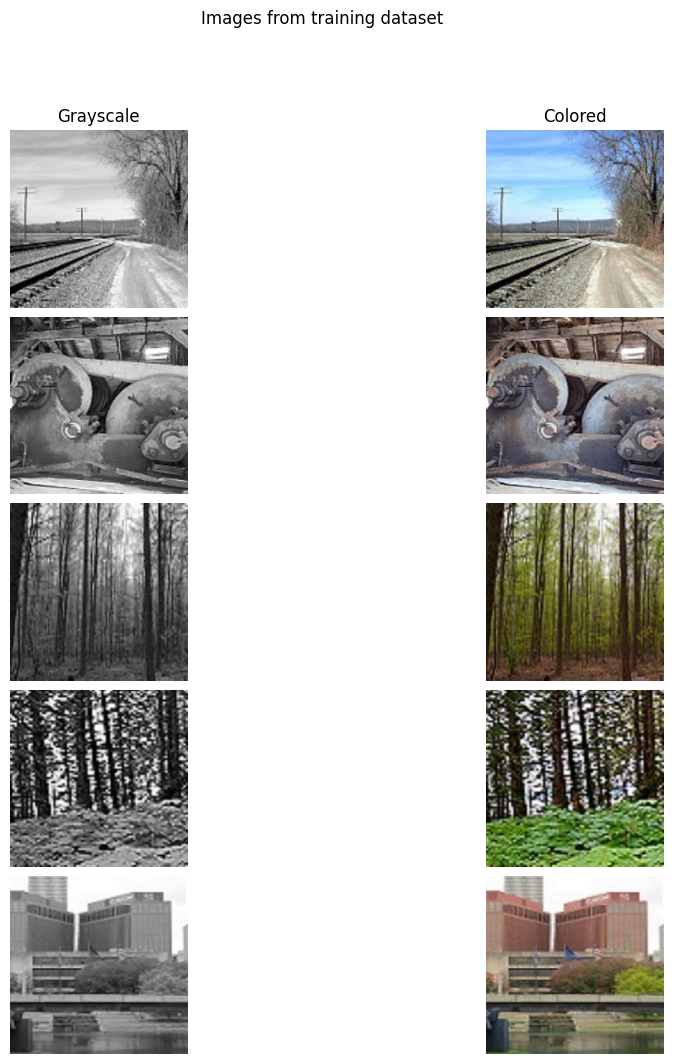

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12))
data = next(iter(train_dl))
for i in range(5):
    grayscale_img = postprocess_rgb(data['gray'])[i]
    rgb_img = postprocess_rgb(data['colored'])[i]
    ax[i, 0].imshow(grayscale_img, cmap='gray')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(rgb_img)
    ax[i, 1].axis('off')

fig.suptitle('Images from training dataset')
ax[0, 0].set_title('Grayscale')
ax[0, 1].set_title('Colored')
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Minimal spacing
plt.show()
plt.close()

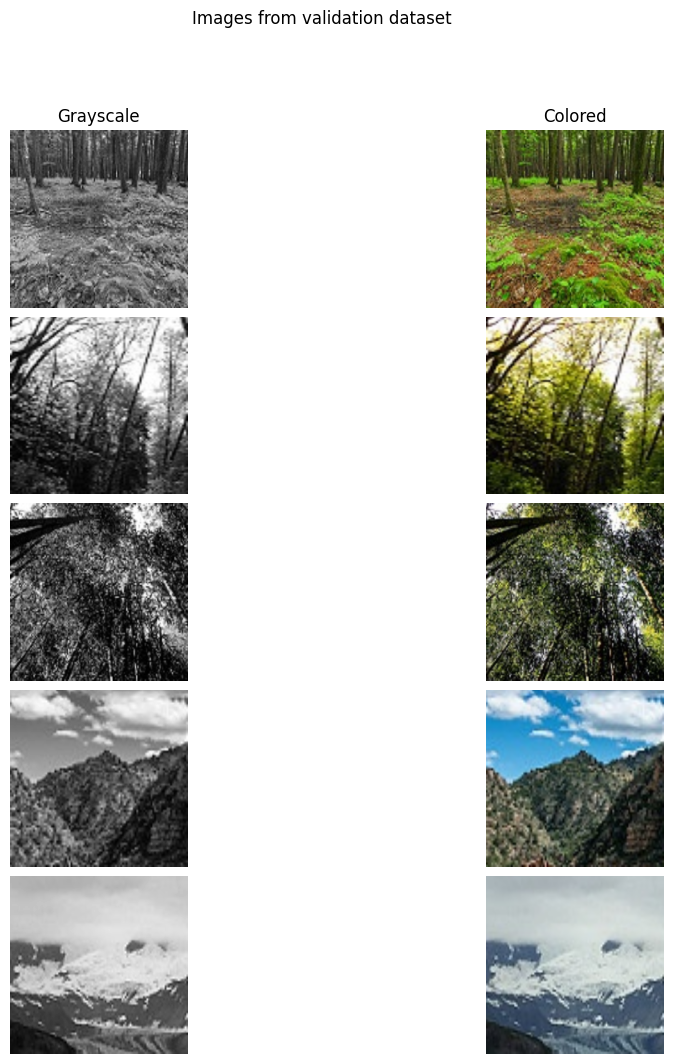

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(12, 12))
data = next(iter(val_dl))
for i in range(5):
    grayscale_img = postprocess_rgb(data['gray'])[i]
    rgb_img = postprocess_rgb(data['colored'])[i]
    ax[i, 0].imshow(grayscale_img, cmap='gray')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(rgb_img)
    ax[i, 1].axis('off')

fig.suptitle('Images from validation dataset')
ax[0, 0].set_title('Grayscale')
ax[0, 1].set_title('Colored')
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Minimal spacing
plt.show()
plt.close()

# Models definitions

## Generator

In [20]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, down: bool=True, act: str="relu", use_dropout: bool=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4,
                      stride=2, padding=1, bias=False, padding_mode="reflect")
            if down else
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(negative_slope=0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [21]:
class Generator(nn.Module):
    def __init__(self, in_channels: int=1, out_channels: int=CONFIG.n_output, features: int=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=4,
                      stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(negative_slope=0.2),
        )
        
        self.down1 = Block(features, features * 2, act="leaky")
        self.down2 = Block(features * 2, features * 4, act="leaky")
        self.down3 = Block(features * 4, features * 8, act="leaky")
        self.down4 = Block(features * 8, features * 8, act="leaky")
        self.down5 = Block(features * 8, features * 8, act="leaky")
        self.down6 = Block(features * 8, features * 8, act="leaky")
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, kernel_size=4,
                      stride=2, padding=1),
            nn.ReLU(),
        )
        self.up1 = Block(features * 8, features * 8, down=False, use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False)
        self.up5 = Block(features * 8 * 2, features * 4, down=False)
        self.up6 = Block(features * 4 * 2, features * 2, down=False)
        self.up7 = Block(features * 2 * 2, features, down=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], dim=1))
        up3 = self.up3(torch.cat([up2, d6], dim=1))
        up4 = self.up4(torch.cat([up3, d5], dim=1))
        up5 = self.up5(torch.cat([up4, d4], dim=1))
        up6 = self.up6(torch.cat([up5, d3], dim=1))
        up7 = self.up7(torch.cat([up6, d2], dim=1))
        return self.final_up(torch.cat([up7, d1], dim=1))

In [22]:
class GeneratorWithResNet(nn.Module):
    def __init__(self, in_channels: int=1, out_channels: int=CONFIG.n_output, img_size: int=CONFIG.img_size):
        super().__init__()
        backbone = resnet18(weights='DEFAULT')
        backbone.conv1 = nn.Conv2d(
            in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )

        body = nn.Sequential(*list(backbone.children())[:-2])
        self.model = DynamicUnet(body, out_channels, (img_size, img_size))

    def forward(self, x):
        return self.model(x)

In [23]:
net_G = Generator(in_channels=1, out_channels=3)

input_img = torch.randn(size=(CONFIG.batch_size, 1, CONFIG.img_size, CONFIG.img_size))
output = net_G(input_img)
print(output.shape)

torch.Size([128, 3, 256, 256])


In [24]:
net_G_resnet = GeneratorWithResNet(in_channels=1, out_channels=3).to('cuda')

input_img = torch.randn(size=(8, 1, CONFIG.img_size, CONFIG.img_size)).to('cuda')
output = net_G_resnet(input_img)
print(output.shape)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


torch.Size([8, 3, 256, 256])


## Discriminator

In [25]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride,
                      padding=1, bias=False, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(negative_slope=0.2),
        )
    
    def forward(self, x):
        return self.conv(x)

In [26]:
class Discriminator(nn.Module):
    def __init__(self, in_channels: int=3, features: list=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(1 + in_channels, features[0], kernel_size=4,
                      stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=0.2),
        )
        
        layers = []
        in_channels = features[0]
        
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        
        layers.append(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1,
                      padding=1, padding_mode='reflect')
        )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, y):
        """Forward pass of the Discriminator

        Args:
            x (torch.Tensor): Batch of grayscale images
            y (torch.Tensor): Batch of colorized images

        Returns:
            _type_: _description_
        """
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [27]:
class DiscriminatorWithResNet(nn.Module):
    def __init__(self, in_channels: int=3, features: list=[64, 128, 256, 512]):
        super().__init__()
        backbone = resnet18(weights='DEFAULT')
        # Modify the first layer to accept the desired input channels
        backbone.conv1 = nn.Conv2d(
            in_channels + 1, features[0], kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        
        # Use the resnet18 as the feature extractor, excluding last 3 layers
        self.backbone = nn.Sequential(*list(backbone.children())[:-3])
        backbone_out_channels = 256  # Last output channels from resnet18’s selected layers
        
        self.additional_layers = nn.Sequential(
            CNNBlock(backbone_out_channels, backbone_out_channels * 2, stride=1),
            CNNBlock(backbone_out_channels * 2, backbone_out_channels * 2, stride=1),
        )
        
        # Add a final convolutional layer to get output size (BATCH, 1, 18, 18)
        self.final_layer = nn.Conv2d(backbone_out_channels * 2, 1, kernel_size=3, stride=1, padding=3, padding_mode='reflect')

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.backbone(x)
        x = self.additional_layers(x)
        return self.final_layer(x)

In [28]:
net_D = Discriminator()

x = torch.randn(size=(CONFIG.batch_size, 1, CONFIG.img_size, CONFIG.img_size))
y = torch.randn(size=(CONFIG.batch_size, 3, CONFIG.img_size, CONFIG.img_size))
output = net_D(x, y)
print(output.shape)

torch.Size([128, 1, 30, 30])


In [29]:
net_D_resnet = DiscriminatorWithResNet().to('cuda')

x = torch.randn(size=(8, 1, CONFIG.img_size, CONFIG.img_size)).to('cuda')
y = torch.randn(size=(8, 3, CONFIG.img_size, CONFIG.img_size)).to('cuda')
output = net_D_resnet(x, y)
print(output.shape)

torch.Size([8, 1, 18, 18])


## Summary of models

In [30]:
summary(net_G.to(CONFIG.device), input_size=(1, CONFIG.img_size, CONFIG.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,088
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
   InstanceNorm2d-12          [-1, 512, 16, 16]           1,024
        LeakyReLU-13          [-1, 512, 16, 16]               0
            Block-14          [-1, 512,

In [31]:
summary(net_G_resnet, input_size=(1, CONFIG.img_size, CONFIG.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [32]:
class DiscriminatorWrapper(nn.Module):
    def __init__(self, net_D, y_dim):
        super().__init__()
        self.net_D = net_D
        self.y_dim = y_dim

    def forward(self, x):
        y = torch.randn((x.size(0), *self.y_dim), device=x.device)
        return self.net_D(x, y)


y_dim = (3, CONFIG.img_size, CONFIG.img_size)
net_D_wrapper = DiscriminatorWrapper(net_D, y_dim)
summary(net_D_wrapper.to(CONFIG.device), input_size=(1, CONFIG.img_size, CONFIG.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           4,160
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
          CNNBlock-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
         CNNBlock-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,152
   InstanceNorm2d-12          [-1, 512, 31, 31]           1,024
        LeakyReLU-13          [-1, 512, 31, 31]               0
         CNNBlock-14          [-1, 512,

In [33]:
net_D_wrapper = DiscriminatorWrapper(net_D_resnet, y_dim)
summary(net_D_wrapper.to(CONFIG.device), input_size=(1, CONFIG.img_size, CONFIG.img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          12,544
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## Loss function

In [34]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = nn.BCEWithLogitsLoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# Training Pipeline

In [35]:
def create_models():
    if CONFIG.resnet_backbone:
        net_G = GeneratorWithResNet(out_channels=CONFIG.n_output, img_size=CONFIG.img_size).to(CONFIG.device)
        net_D = DiscriminatorWithResNet().to(CONFIG.device)
    else:
        net_G = Generator(in_channels=CONFIG.n_input, out_channels=CONFIG.n_output).to(CONFIG.device)
        net_D = Discriminator().to(CONFIG.device)
    
    criterion_GAN = GANLoss().to(CONFIG.device)
    criterion_L1 = torch.nn.L1Loss().to(CONFIG.device)
    
    optimizer_G = torch.optim.Adam(net_G.parameters(), lr=CONFIG.generator_lr, betas=CONFIG.betas)
    optimizer_D = torch.optim.Adam(net_D.parameters(), lr=CONFIG.discriminator_lr, betas=CONFIG.betas)
    
    return net_G, net_D, criterion_GAN, criterion_L1, optimizer_G, optimizer_D

In [36]:
# Define transformations
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),              # Randomly flip the image horizontally with a 50% chance
    A.RandomRotate90(p=0.5),              # Randomly rotate the image by 90 degrees with a 50% chance
    A.RandomResizedCrop(height=CONFIG.img_size, width=CONFIG.img_size, scale=(0.5, 1.0), p=1),  # Randomly zoom in or out
    ToTensorV2(),
], additional_targets={'colored': 'image'})

val_transforms = A.Compose([
    A.RandomResizedCrop(height=CONFIG.img_size, width=CONFIG.img_size, scale=(0.5, 1.0), p=1),  # Randomly zoom in or out
    ToTensorV2(),
], additional_targets={'colored': 'image'})


def create_dataloaders():
    train_ds = CustomDataset(CONFIG.train_images_dir, transform=train_transforms)
    val_ds = CustomDataset(CONFIG.val_images_dir, split='val', transform=val_transforms)
    train_dl = DataLoader(train_ds, batch_size=CONFIG.batch_size, shuffle=True,
                          pin_memory=True, num_workers=CONFIG.num_workers)
    val_dl = DataLoader(val_ds, batch_size=CONFIG.batch_size, shuffle=False,
                        pin_memory=True, num_workers=CONFIG.num_workers)
    return train_dl, val_dl

In [37]:
def train_rgb(dataloader, net_G, net_D, criterion_GAN, criterion_L1,
              optim_G, optim_D, scaler_G, scaler_D, epoch) -> dict:
    net_G.train()
    net_D.train()
    
    losses = create_loss_meters()  # create the loss meters for the Discriminator and Generator
    loop = tqdm(enumerate(dataloader))
    for idx, data in loop:
        gray, colored = data['gray'].to(CONFIG.device), data['colored'].to(CONFIG.device)
        
        # Train the Discriminator
        for param in net_D.parameters():
            param.requires_grad = True
        
        optim_D.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            fake_colored = net_G(gray)
            fake_preds = net_D(gray, fake_colored.detach())
            real_preds = net_D(gray, colored)
            
            loss_D_fake = criterion_GAN(fake_preds, False)
            loss_D_real = criterion_GAN(real_preds, True)
            loss_D = (loss_D_fake + loss_D_real) / 2
        
        scaler_D.scale(loss_D).backward()
        scaler_D.step(optim_D)
        scaler_D.update()
        losses['loss_D_fake'].update(loss_D_fake.item(), gray.shape[0])
        losses['loss_D_real'].update(loss_D_real.item(), gray.shape[0])
        losses['loss_D'].update(loss_D.item(), gray.shape[0])
        
        # Train the Generator
        for param in net_D.parameters():
            param.requires_grad = False
        
        optim_G.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            fake_preds = net_D(gray, fake_colored)
            
            loss_G_GAN = criterion_GAN(fake_preds, True)
            loss_G_L1 = criterion_L1(fake_colored, colored)
            loss_G = loss_G_GAN + CONFIG.l1_lambda * loss_G_L1
            
        scaler_G.scale(loss_G).backward()
        scaler_G.step(optim_G)
        scaler_G.update()
        losses['loss_G_GAN'].update(loss_G_GAN.item(), gray.shape[0])
        losses['loss_G_L1'].update(loss_G_L1.item(), gray.shape[0])
        losses['loss_G'].update(loss_G.item(), gray.shape[0])
        
        loop.set_description(f'Epoch [{epoch}/{CONFIG.epochs}]')
        loop.set_postfix(loss_D=loss_D.item(), loss_G=loss_G.item())
    return losses

In [38]:
def train_lab(dataloader, net_G, net_D, criterion_GAN, criterion_L1,
          optim_G, optim_D, scaler_G, scaler_D, epoch) -> dict:
    net_G.train()
    net_D.train()
    
    losses = create_loss_meters()  # create the loss meters for the Discriminator and Generator
    loop = tqdm(enumerate(dataloader))
    for idx, data in loop:
        L, AB = data['gray'].to(CONFIG.device), data['colored'].to(CONFIG.device)
        
        # Train the Discriminator
        for param in net_D.parameters():
            param.requires_grad = True
        
        optim_D.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            fake_AB = net_G(L)
            fake_image = torch.cat([L, fake_AB], dim=1)
            fake_preds = net_D(L, fake_image.detach())  # detach the fake image to avoid computing gradients for the Generator
            real_image = torch.cat([L, AB], dim=1)
            real_preds = net_D(L, real_image)
            
            loss_D_fake = criterion_GAN(fake_preds, False)
            loss_D_real = criterion_GAN(real_preds, True)
            loss_D = (loss_D_fake + loss_D_real) / 2
        
        scaler_D.scale(loss_D).backward()
        scaler_D.step(optim_D)
        scaler_D.update()
        losses['loss_D_fake'].update(loss_D_fake.item(), L.shape[0])
        losses['loss_D_real'].update(loss_D_real.item(), L.shape[0])
        losses['loss_D'].update(loss_D.item(), L.shape[0])
        
        # Train the Generator
        for param in net_D.parameters():
            param.requires_grad = False  # freeze the Discriminator parameters
        
        optim_G.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda'):
            fake_image = torch.cat([L, fake_AB], dim=1)
            fake_preds = net_D(L, fake_image)
            
            loss_G_GAN = criterion_GAN(fake_preds, True)
            loss_G_L1 = criterion_L1(fake_AB, AB)  # L1 loss between the generated AB channels and the true AB channels
            loss_G = loss_G_GAN + CONFIG.l1_lambda * loss_G_L1
        
        scaler_G.scale(loss_G).backward()
        scaler_G.step(optim_G)
        scaler_G.update()
        losses['loss_G_GAN'].update(loss_G_GAN.item(), L.shape[0])
        losses['loss_G_L1'].update(loss_G_L1.item(), L.shape[0])
        losses['loss_G'].update(loss_G.item(), L.shape[0])
        
        loop.set_description(f'Epoch [{epoch}/{CONFIG.epochs}]')
        loop.set_postfix(loss_D=loss_D.item(), loss_G=loss_G.item())
    return losses

In [39]:
def main():
    output_format = 'ab'
    resnet_backbone = True

    if resnet_backbone:
        CONFIG.resnet_backbone = True
        CONFIG.batch_size = 16
    
    if output_format == 'rgb':
        CONFIG.output_format = 'rgb'
        CONFIG.n_output = 3
        train = train_rgb
    elif output_format == 'ab':
        CONFIG.output_format = 'ab'
        CONFIG.n_output = 2
        train = train_lab
    else:
        raise ValueError(f'Output format must be either "rgb" or "ab", got {output_format}')
    
    # Save the model and training configurations to a JSON file
    CONFIG.save_config(filename='config.json')
    print('Run configurations are saved!')
    
    train_dl, val_dl = create_dataloaders()
    net_G, net_D, criterion_GAN, criterion_L1, optimizer_G, optimizer_D = create_models()
    scaler_G = torch.amp.GradScaler('cuda')
    scaler_D = torch.amp.GradScaler('cuda')
    
    # Load the models if the flag is set to True
    if CONFIG.load_models:
        load_checkpoints(net_G, optimizer_G, 'checkpoints_dir...', f'gen_checkpoints_{CONFIG.start_epoch}.pth.tar', CONFIG.generator_lr)
        load_checkpoints(net_D, optimizer_D, 'checkpoints_dir...', f'disc_checkpoints_{CONFIG.start_epoch}.pth.tar', CONFIG.discriminator_lr)
    
    torch.cuda.empty_cache()  # free up some memory before training the GAN
    print('Starting training GAN...')
    for epoch in range(CONFIG.start_epoch + 1, CONFIG.start_epoch + CONFIG.epochs + 1):
        losses = train(train_dl, net_G, net_D, criterion_GAN, criterion_L1,
                       optimizer_G, optimizer_D, scaler_G, scaler_D, epoch)
        log_training(losses, epoch)
        for _, meter in losses.items():
            meter.reset()  # reset the loss meters for the next epoch
        
        if epoch % CONFIG.save_checkpoints_freq == 0:
            if CONFIG.save_models:
                save_checkpoints(net_G, optimizer_G, CONFIG.checkpoints_dir, f'gen_checkpoints_{epoch}.pth.tar')
                save_checkpoints(net_D, optimizer_D, CONFIG.checkpoints_dir, f'disc_checkpoints_{epoch}.pth.tar')
        if epoch % CONFIG.save_images_freq == 0:
            if CONFIG.save_examples:
                save_examples(net_G, val_dl, epoch, CONFIG.examples_dir)
    print('Training is complete!')

In [40]:
main()

Run configurations are saved!
Starting training GAN...


Epoch [1/50]: : 357it [03:16,  1.82it/s, loss_D=0.888, loss_G=5.96]
Epoch [2/50]: : 357it [03:15,  1.82it/s, loss_D=0.264, loss_G=6.73]
Epoch [3/50]: : 357it [03:15,  1.82it/s, loss_D=0.811, loss_G=6.23]
Epoch [4/50]: : 357it [03:16,  1.82it/s, loss_D=1.01, loss_G=6.19]
Epoch [5/50]: : 357it [03:16,  1.82it/s, loss_D=0.468, loss_G=9.09]
Epoch [6/50]: : 357it [03:16,  1.82it/s, loss_D=0.72, loss_G=6.45]
Epoch [7/50]: : 357it [03:16,  1.82it/s, loss_D=0.8, loss_G=5.22]
Epoch [8/50]: : 357it [03:16,  1.82it/s, loss_D=1.46, loss_G=7.62]
Epoch [9/50]: : 357it [03:16,  1.82it/s, loss_D=1.53, loss_G=11.1]
Epoch [10/50]: : 357it [03:16,  1.82it/s, loss_D=0.222, loss_G=8.62]


=> Saving checkpoints
=> Saving checkpoints


Epoch [11/50]: : 357it [03:15,  1.82it/s, loss_D=0.753, loss_G=4.7]
Epoch [12/50]: : 357it [03:15,  1.82it/s, loss_D=1.92, loss_G=8.2]
Epoch [13/50]: : 357it [03:16,  1.82it/s, loss_D=0.361, loss_G=7.06]
Epoch [14/50]: : 357it [03:16,  1.82it/s, loss_D=0.0796, loss_G=10.3]
Epoch [15/50]: : 357it [03:16,  1.82it/s, loss_D=0.278, loss_G=10.1]
Epoch [16/50]: : 357it [03:16,  1.82it/s, loss_D=1.5, loss_G=5.79]
Epoch [17/50]: : 357it [03:16,  1.82it/s, loss_D=2.36, loss_G=9.43]
Epoch [18/50]: : 357it [03:15,  1.82it/s, loss_D=0.0572, loss_G=10]
Epoch [19/50]: : 357it [03:15,  1.82it/s, loss_D=0.0564, loss_G=8.79]
Epoch [20/50]: : 357it [03:15,  1.82it/s, loss_D=0.119, loss_G=10]


=> Saving checkpoints
=> Saving checkpoints


Epoch [21/50]: : 357it [03:15,  1.82it/s, loss_D=0.0253, loss_G=8.79]
Epoch [22/50]: : 357it [03:15,  1.82it/s, loss_D=0.356, loss_G=11.3]
Epoch [23/50]: : 357it [03:15,  1.82it/s, loss_D=0.0549, loss_G=10.9]
Epoch [24/50]: : 357it [03:15,  1.82it/s, loss_D=0.203, loss_G=7.8]
Epoch [25/50]: : 357it [03:15,  1.82it/s, loss_D=0.0194, loss_G=12.6]
Epoch [26/50]: : 357it [03:15,  1.82it/s, loss_D=0.372, loss_G=11.3]
Epoch [27/50]: : 357it [03:15,  1.82it/s, loss_D=0.0977, loss_G=12.2]
Epoch [28/50]: : 357it [03:15,  1.82it/s, loss_D=1.86, loss_G=6.36]
Epoch [29/50]: : 357it [03:15,  1.82it/s, loss_D=0.0551, loss_G=9.78]
Epoch [30/50]: : 357it [03:15,  1.82it/s, loss_D=0.0264, loss_G=8.77]


=> Saving checkpoints
=> Saving checkpoints


Epoch [31/50]: : 357it [03:15,  1.82it/s, loss_D=0.141, loss_G=11.3]
Epoch [32/50]: : 357it [03:15,  1.82it/s, loss_D=0.0141, loss_G=12.2]
Epoch [33/50]: : 357it [03:15,  1.82it/s, loss_D=1.32, loss_G=9.45]
Epoch [34/50]: : 357it [03:15,  1.82it/s, loss_D=1.52, loss_G=6.27]
Epoch [35/50]: : 357it [03:15,  1.82it/s, loss_D=0.00297, loss_G=13.5]
Epoch [36/50]: : 357it [03:16,  1.82it/s, loss_D=0.514, loss_G=9.17]
Epoch [37/50]: : 357it [03:15,  1.82it/s, loss_D=2.38, loss_G=11.9]
Epoch [38/50]: : 357it [03:15,  1.82it/s, loss_D=0.00887, loss_G=13.1]
Epoch [39/50]: : 357it [03:15,  1.82it/s, loss_D=2.23, loss_G=10.7]
Epoch [40/50]: : 357it [03:15,  1.82it/s, loss_D=2.31, loss_G=7.35]


=> Saving checkpoints
=> Saving checkpoints


Epoch [41/50]: : 357it [03:15,  1.82it/s, loss_D=1.4, loss_G=5.85]
Epoch [42/50]: : 357it [03:15,  1.82it/s, loss_D=0.276, loss_G=7.96]
Epoch [43/50]: : 357it [03:15,  1.82it/s, loss_D=1.86, loss_G=7.79]
Epoch [44/50]: : 357it [03:15,  1.82it/s, loss_D=0.578, loss_G=9.25]
Epoch [45/50]: : 357it [03:15,  1.82it/s, loss_D=0.0283, loss_G=11.1]
Epoch [46/50]: : 357it [03:15,  1.82it/s, loss_D=0.422, loss_G=9.79]
Epoch [47/50]: : 357it [03:15,  1.82it/s, loss_D=0.273, loss_G=10.6]
Epoch [48/50]: : 357it [03:15,  1.82it/s, loss_D=0.14, loss_G=10.1]
Epoch [49/50]: : 357it [03:15,  1.82it/s, loss_D=0.763, loss_G=9.25]
Epoch [50/50]: : 357it [03:15,  1.82it/s, loss_D=0.0279, loss_G=13.5]


=> Saving checkpoints
=> Saving checkpoints
Training is complete!
